# Preprocessing

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2')

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2


100%|██████████| 744M/744M [00:03<00:00, 204MB/s]


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import shutil
from sklearn.model_selection import train_test_split

## Splitting Data

In [3]:
# Set paths
ORIGINAL_DATASET = "/content/garbage-classification-v2/garbage-dataset"
BASE_DIR = "garbage_data"  # Output directory

# Create folders
for split in ["train", "val", "test"]:
    for category in os.listdir(ORIGINAL_DATASET):
        os.makedirs(os.path.join(BASE_DIR, split, category), exist_ok=True)

# Split data
for category in os.listdir(ORIGINAL_DATASET):
    category_path = os.path.join(ORIGINAL_DATASET, category)
    images = os.listdir(category_path)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

    for img_name in train_imgs:
        shutil.copy(os.path.join(category_path, img_name), os.path.join(BASE_DIR, "train", category, img_name))

    for img_name in val_imgs:
        shutil.copy(os.path.join(category_path, img_name), os.path.join(BASE_DIR, "val", category, img_name))

    for img_name in test_imgs:
        shutil.copy(os.path.join(category_path, img_name), os.path.join(BASE_DIR, "test", category, img_name))

print("Done splitting dataset!")

Done splitting dataset!


## Sample count per class

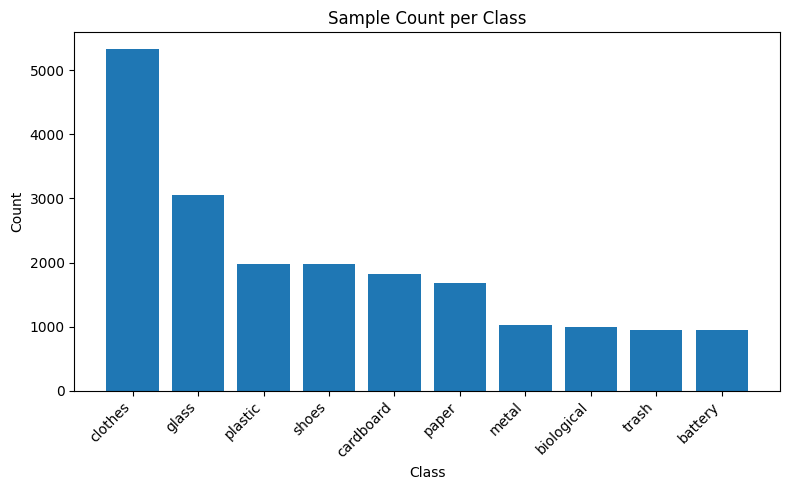

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_counts(data_dir, output_path=None):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    counts = {cls: len([f for f in os.listdir(os.path.join(data_dir, cls))
                        if f.lower().endswith((".jpg",".jpeg",".png"))])
              for cls in classes}
    df = pd.DataFrame(list(counts.items()), columns=["class","count"]).sort_values("count", ascending=False)
    # plot
    plt.figure(figsize=(8,5))
    plt.bar(df['class'], df['count'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Sample Count per Class')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()

plot_counts(r'/content/garbage-classification-v2/garbage-dataset', 'countplot.png')

## Preprocessing and Augmentation using ```ImageDataGenerator```

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

val_test_gen = ImageDataGenerator(rescale=1./255)

# Load the data
train_data = train_gen.flow_from_directory(
    "garbage_data/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    "garbage_data/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    "garbage_data/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for consistent test evaluation
)

## Using ```resnet50 ```'s ```preprocess_input``` to preprocess the data



In [5]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_test_gen   = ImageDataGenerator(preprocessing_function=preprocess_input)

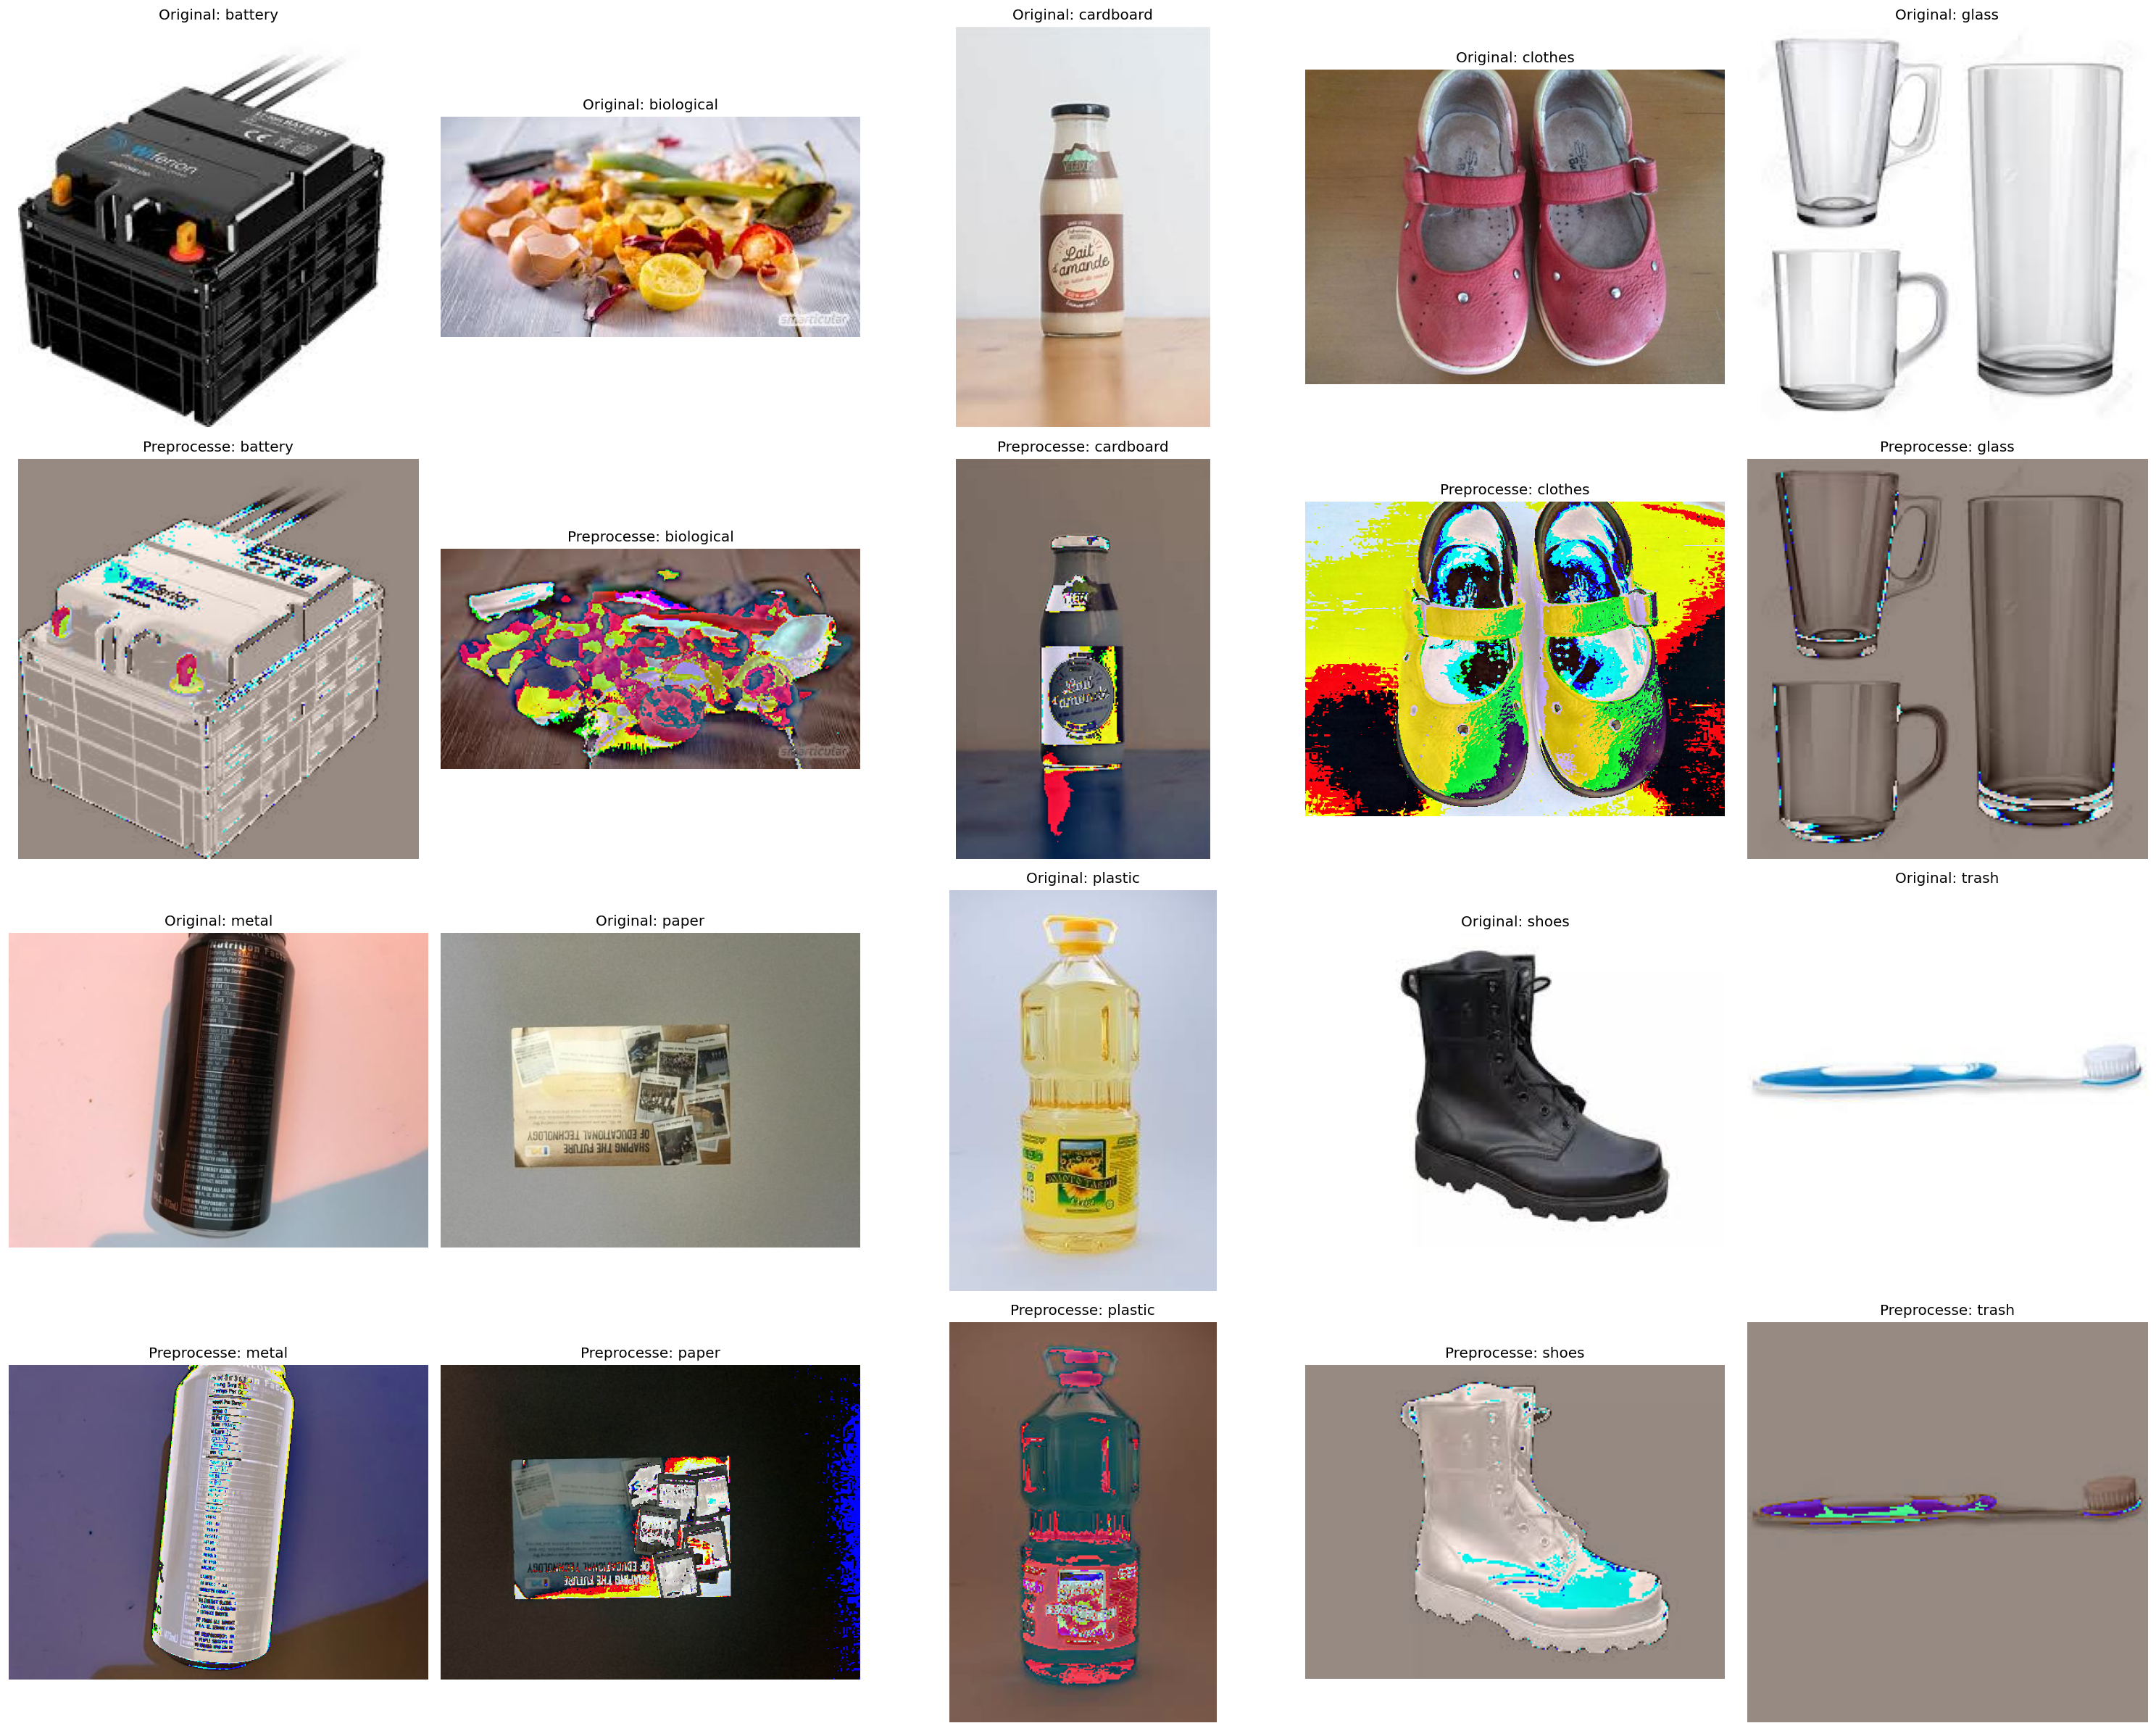

In [34]:
def plot_image_vs_preprocessed():
  fig, axs = plt.subplots(4, 5, figsize=(25, 20), dpi=120)
  i = 0

  for category in sorted(os.listdir(ORIGINAL_DATASET))[:10]:  # Ensure exactly 10 categories
      category_path = os.path.join(ORIGINAL_DATASET, category)
      images = os.listdir(category_path)
      idx = np.random.randint(0, len(images))

      # Load original image
      img = load_img(os.path.join(category_path, images[idx]))
      x = img_to_array(img)
      x = x.reshape((1,) + x.shape)

      # Compute row and column positions
      row_base = (i // 5) * 2  # 0 or 2
      col = i % 5              # 0 to 4

      # Show original image
      axs[row_base, col].imshow(img)
      axs[row_base, col].set_title(f'Original: {category}', fontsize=12)
      axs[row_base, col].axis('off')

      # Generate and show one augmented image
      for batch in train_gen.flow(x, batch_size=1):
          axs[row_base + 1, col].imshow(batch[0].astype('uint8'))
          axs[row_base + 1, col].set_title(f'Preprocesse: {category}', fontsize=12)
          axs[row_base + 1, col].axis('off')
          break

      i += 1

  plt.tight_layout()
  plt.savefig('trainingDataBeforeAndAfterPreprocessing.png')
  plt.show()

plot_image_vs_preprocessed()

## Loading the data

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load the data
def get_train_generator(train_dir):
  print(f"Inside get_train_generator. Received train_dir: {train_dir}")
  return train_gen.flow_from_directory(train_dir,
                                      target_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE,
                                      class_mode='categorical')

def get_val_test_generator(val_test):
  print(f"Inside get_val_test_generator. Received val_test: {val_test}")
  return val_test_gen.flow_from_directory(val_test,
                                      target_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE,
                                      class_mode='categorical',
                                      shuffle=False)

train_data = get_train_generator(os.path.join(BASE_DIR, "train"))
val_data = get_val_test_generator(os.path.join(BASE_DIR, "val"))
test_data = get_val_test_generator(os.path.join(BASE_DIR, "test"))

Inside get_train_generator. Received train_dir: garbage_data/train
Found 13827 images belonging to 10 classes.
Inside get_val_test_generator. Received val_test: garbage_data/val
Found 3972 images belonging to 10 classes.
Inside get_val_test_generator. Received val_test: garbage_data/test
Found 1963 images belonging to 10 classes.


In [37]:
class_names = list(train_data.class_indices.keys())

# Save class names to a file
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)